In [1]:
from lanlab import Text,Batch,Sequential,Sequence
from lanlab import load,save
from lanlab import set_number_workers

import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
import os

import warnings
warnings.filterwarnings("ignore")

set_number_workers(16) #Set the number of workers to 16 to generate the data faster

genome_name = 'math' #Math set of genes : llemaf_nostop // Code set of genes : codef_nostop

/home/nyax/git/PhyloLM/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading genome and alleles

In [2]:
#Load the genes
def load_genome(genome_name,G=128):
    genes_batch = Batch((G,))
    for i in range(G):
        genes_batch[i] = load(os.path.join('data','kl_pop',genome_name,'genes',str(i)))
    return genes_batch

In [3]:
#For each model in models generate nb_probes completions of 1 token to each prefix
def compute_P(models,genome,save_name,N=32):
    #Start from an empty batch
    P = [[{} for _ in range(len(models))] for _ in range(len(genome))]
    for j,m in enumerate(models):
        for k in range(N):
            print('Computing probe '+str(k)+' for model '+m.name)
            generate_pipeline = Sequential(m.configure(max_tokens=5))#,logit_bias={'50256':-100}))
            #Generate the prefix
            loaded_batch = generate_pipeline(genome,os.path.join('data','kl_pop',save_name,'probes_batch',m.name,str(k)))
            probes = np.zeros((len(genome),),dtype=object)
            for idx in range(len(genome)):
                probes[idx] = loaded_batch[idx][-1]['text'] #Get the completion (that should be the last segment in the sequence)
                probes[idx] = probes[idx].lstrip(' ').lstrip('\n')[:4] #Get the first 4 characters of the completion
                P[idx][j][probes[idx]] = P[idx][j].get(probes[idx],0)+1 #Set it as allele in matrix P(gene,model,allele)
    #Normalize the multiplicity of each probe to get probabilities
    for i in range(len(genome)):
        for j in range(len(models)):
            for k in P[i][j]:
                P[i][j][k] /= N
    return P

def match(d,k):
    if k in d:
        return d[k]
    else:
        return 0

def compute_nei_similarity(P,model_indexs,model_indexs2=None):
    #Compute similarity matrix S
    if model_indexs2 is None:
        model_indexs2 = model_indexs
    nei_sim = np.zeros((len(model_indexs),len(model_indexs2)))
    #Iterate over all pairs of models to compute each similarity
    for i in range(len(model_indexs)):
        index_i = model_indexs[i]
        for j in range(len(model_indexs2)):
            #compute the different parts of the nei formula
            up = 0
            dleft = 0
            dright = 0
            index_j = model_indexs2[j]
            for k in range(len(P)):
                for l in {**P[k][index_i],**P[k][index_j]}:
                    up += match(P[k][index_i],l)*match(P[k][index_j],l)
                for l in P[k][index_i]:
                    dleft += P[k][index_i][l]**2
                for l in P[k][index_j]:
                    dright += P[k][index_j][l]**2
            nei_sim[i,j] = up/(dleft*dright)**0.5
    return nei_sim
    

In [4]:
from lanlab.core.module.models import *

#All the models included in the study :
models = [

          Llama7B(),'llama 1-7',
          Alpaca7B(),'llama 1-7',
          Wizard7B(),'llama 1-7',
          Vicuna7B_11(),'llama 1-7',
          Vicuna7B_13(),'llama 1-7',
          Baize7B(),'llama 1-7',
          ChimeraInstChat7B(),'llama 1-7',

          Llama13B(),'llama 1-13',
          Vicuna13B_11(),'llama 1-13',
          Vicuna13B_13(),'llama 1-13',
          OpenChat2(),'llama 1-13',
          OpenChat2W(),'llama 1-13',
          ChimeraInstChat13B(),'llama 1-13',

          Llama2HF_7B(),'llama 2-7',
          Orca2_7B(),'llama 2-7',
          TigerBotBase_7B(),'llama 2-7',
          TigerBotChat_7B(),'llama 2-7',
          OpenHermes7B(),'llama 2-7',
          Vicuna7B_15(),'llama 2-7',

          Llama2HF_13B(),'llama 2-13',
          OpenChat31(),'llama 2-13',
          OpenChat32(),'llama 2-13',
          OpenHermes13B(),'llama 2-13',
          Vicuna13B_15(),'llama 2-13',
          OpenChat32Super(),'llama 2-13',
          TigerBotBasev1_13B(),'llama 2-13',
          TigerBotBasev2_13B(),'llama 2-13',
          TigerBotChatv1_13B(),'llama 2-13',
          TigerBotChatv2_13B(),'llama 2-13',
          TigerBotChatv3_13B(),'llama 2-13',
          TigerBotChatv4_13B(),'llama 2-13',

          Bloom3B(),'bloom',
          Bloom7B(),'bloom',
          BloomZ3B(),'bloom',
          BloomZ7B(),'bloom',
          TigerBotBasev1_7B(),'bloom',
          TigerBotBasev2_7B(), 'bloom',
          TigerBotSFTv1_7B(),'bloom',
          TigerBotSFTv2_7B(),'bloom',
          PhoenixInstChat7B(),'bloom',
          Bloom176B(),'bloom',

          Pythia70M(),'pythia',
          Pythia160M(),'pythia',
          Pythia410M(),'pythia',
          Pythia1B(),'pythia',
          Pythia3B(),'pythia',
          Pythia7B(),'pythia',
          Pythia12B(),'pythia',
          Dolly3B(),'pythia',
          Dolly7B(),'pythia',
          Dolly12B(),'pythia',
          OasstSft4Pythia12bEpoch35(),'pythia',

          OPT125M(),'opt',
          OPT350M(),'opt',
          OPT1B(),'opt',
          OPT3B(),'opt',
          OPT7B(),'opt',
          OPT13B(),'opt',
          OPT30B(),'opt',
          OPT66B(),'opt',

          FalconRW1B(),'falcon',
          FalconRW7B(),'falcon',
          Falcon7B(),'falcon',
          Falcon7BI(),'falcon',
          Falcon40B(),'falcon',
            Falcon40BI(),'falcon',
            Falcon180B(),'falcon',

          Mistral7B(),'mistral',
          Mistral7BI(),'mistral',
          Mistral7BInstructV02(),'mistral',
          Zephyr7BA(),'mistral',
          Zephyr7BB(),'mistral',
          Docsgpt7BMistral(),'mistral',
          OpenChat35(),'mistral',
          TenyxChat7B(),'mistral',
          MedChat35(),'mistral',
          NeuralChat3_7B(),'mistral',
          NeuralChat31_7B(),'mistral',
          OpenHermes2_7B(),'mistral',
          OpenHermes25_7B(),'mistral',
          HarmoniousAnthea(),'mistral',
          NeuralHermes25Mistral7B(),'mistral',
          Mixtral8x7BV01(),'mistral',
          Mixtral8x7BInstructV01(),'mistral',
          
          

          QWEN2B(),'qwen',
          QWEN7B(),'qwen',
          QWEN14B(),'qwen',
          QWEN72B(),'qwen',
          CausalLM7B(),'qwen',
          CausalLM14B(),'qwen',

          QWEN15_500M(),'qwen',
          QWEN15_2B(),'qwen',
          QWEN15_4B(),'qwen',
          QWEN15_7B(),'qwen',
          QWEN15_14B(),'qwen',
          QWEN15_32B(),'qwen',
          QWEN15_72B(),'qwen',

          QWEN15Ch_500M(),'qwen',
          QWEN15Ch_2B(),'qwen',
          QWEN15Ch_4B(),'qwen',
          QWEN15Ch_7B(),'qwen',
          QWEN15Ch_14B(),'qwen',
          QWEN15Ch_32B(),'qwen',
          QWEN15Ch_72B(),'qwen',

          

            Gemma2B(),'gemma',
            Gemma2BI(),'gemma',
          Gemma7B(),'gemma',
        Gemma7BI(),'gemma',
        Gemma1p1_2BI(),'gemma',
        Gemma1p1_7BI(),'gemma',
        CodeGemma2B(),'gemma',
        CodeGemma7B(),'gemma',
        CodeGemma7BI(),'gemma',

        AD(),'gpt 3',
          BB(),'gpt 3',
          CU(),'gpt 3',
          DV(),'gpt 3',
          DVB(),'gpt 3',
          TAD1(),'gpt 3',
          TBB1(),'gpt 3',
          TCU1(),'gpt 3',
          TDV1(),'gpt 3',
          
          TDV2(),'gpt 3.5',
          TDV3(),'gpt 3.5',
          BB2(),'gpt 3.5',
          DV2(),'gpt 3.5',
          GPT35I_0914(),'gpt 3.5',]

origins = models[1::2]
models = models[::2]
model_labels = [{'name':m.name,'origin':o, 'engine':m.engine} for m,o in zip(models,origins)]
import logging
logging.basicConfig(level=logging.INFO)


#Load genes
genome = load_genome(genome_name,128)


In [5]:
#Compute Nei similarity
P = compute_P(models,genome,genome_name,N=32)
nei_sim = compute_nei_similarity(P,range(len(models)))

Computing probe 0 for model LLA7
Computing probe 1 for model LLA7
Computing probe 2 for model LLA7
Computing probe 3 for model LLA7
Computing probe 4 for model LLA7
Computing probe 5 for model LLA7
Computing probe 6 for model LLA7
Computing probe 7 for model LLA7
Computing probe 8 for model LLA7
Computing probe 9 for model LLA7
Computing probe 10 for model LLA7
Computing probe 11 for model LLA7
Computing probe 12 for model LLA7
Computing probe 13 for model LLA7
Computing probe 14 for model LLA7
Computing probe 15 for model LLA7
Computing probe 16 for model LLA7
Computing probe 17 for model LLA7
Computing probe 18 for model LLA7
Computing probe 19 for model LLA7
Computing probe 20 for model LLA7
Computing probe 21 for model LLA7
Computing probe 22 for model LLA7
Computing probe 23 for model LLA7
Computing probe 24 for model LLA7
Computing probe 25 for model LLA7
Computing probe 26 for model LLA7
Computing probe 27 for model LLA7
Computing probe 28 for model LLA7
Computing probe 29 for m

### Loading benchmark scores

In [6]:
import json
import os

data = {}

#look for all folders in results except the ones that are not actual results
editors = os.listdir('results')
editors.remove('.gitattributes')
editors.remove('README.md')
editors.remove('.git')

#Load each of these files and store the results in a dictionary
for editor in editors:
    models_list = os.listdir(os.path.join('results',editor))
    for model_name in models_list:
        data[editor+'/'+model_name] = []
        try:
            iterations = sorted(os.listdir(os.path.join('results',editor,model_name)))
            for it in iterations:
                with open(os.path.join('results',editor,model_name,it)) as f:
                    try:
                        data[editor+'/'+model_name].append(json.load(f)['results'])
                    except KeyError:
                        data[editor+'/'+model_name] = [json.load(f)['results']]
        except NotADirectoryError:
            with open(os.path.join('results',editor,model_name)) as f:
                data[editor] = [json.load(f)['results']]


In [7]:
def find_score(url):
    # Return the scores for the model with the url
    found = []
    for mname in data:
        if url and url[23:] == mname:
            found.append(mname)
    #Return the shortest name in found
    sorted_found = sorted(found,key=lambda x: len(x))
    if len(sorted_found) > 0:
        d = {}
        #Get the last iteration of the benchmark evaluation
        for it in range(len(data[sorted_found[0]])):
            for k in data[sorted_found[0]][it]:
                #Get the scores for each benchmark
                if 'arc:challenge' in k and not(data[sorted_found[0]][it][k]['acc_norm'] is None):
                    d['arc'] = data[sorted_found[0]][it][k]['acc_norm']*100
                if 'hellaswag' in k and not(data[sorted_found[0]][it][k]['acc_norm'] is None):
                    d['hellaswag'] = data[sorted_found[0]][it][k]['acc_norm']*100
                if 'hendrycks' in k and not(data[sorted_found[0]][it][k]['acc_norm'] is None):
                    try:
                        d['hendrycks'][k] = data[sorted_found[0]][it][k]['acc_norm']*100
                    except KeyError:
                        d['hendrycks'] = {k:data[sorted_found[0]][it][k]['acc_norm']*100}
                if 'truthfulqa' in k and not(data[sorted_found[0]][it][k]['mc2'] is None):
                    d['truthfulqa'] = data[sorted_found[0]][it][k]['mc2']*100
                if 'winogrande' in k and not(data[sorted_found[0]][it][k]['acc'] is None):
                    d['winogrande'] = data[sorted_found[0]][it][k]['acc']*100
                if 'gsm8k' in k and not(data[sorted_found[0]][it][k]['acc'] is None):
                    d['gsm8k'] = data[sorted_found[0]][it][k]['acc']*100
            #compute mmlu as average of all hendrycks scores
            if 'hendrycks' in d:
                d['mmlu'] = np.mean(list(d['hendrycks'].values()))
            #Put None where there is no score
            for k in ['arc','hellaswag','mmlu','truthfulqa','winogrande','gsm8k']:
                if k not in d:
                    d[k] = None
        # Return the scores
        return d['arc'],d['hellaswag'],d['mmlu'],d['truthfulqa'],d['winogrande'],d['gsm8k']
    else:
        return None

In [8]:
#Load all the scores
scores = {}
for model in models:
    d = find_score(model.url)
    if not(d is None):
        scores[model.name] = d
    else:
        scores[model.name] = [None,None,None,None,None,None]
        print(model.engine,'not found')

wizard-7b not found
vicuna-7b-v1.1 not found
chimera-inst-chat-7b not found
tigerbot-7b-chat not found
tigerbot-13b-base-v1 not found
tigerbot-13b-base-v2 not found
tigerbot-13b-chat-v1 not found
tigerbot-13b-chat-v2 not found
tigerbot-13b-chat-v3 not found
tigerbot-13b-chat-v4 not found
tigerbot-7b-base-v1 not found
tigerbot-7b-base-v2 not found
tigerbot-7b-sft-v1 not found
tigerbot-7b-sft-v2 not found
phoenix-inst-chat-7b not found
pythia-2.8b not found
pythia-6.9b not found
falcon-rw-7b not found
docsgpt-7b-mistral not found
MedChat3.5 not found
H4rmoniousAnthea not found
Qwen-1_8B not found
Qwen1.5-1.8B-Chat not found
gemma-1.1-2b-it not found
ada not found
babbage not found
curie not found
davinci not found
davinci-instruct-beta not found
text-ada-001 not found
text-babbage-001 not found
text-curie-001 not found
text-davinci-001 not found
text-davinci-002 not found
text-davinci-003 not found
babbage-002 not found
davinci-002 not found
gpt-3.5-turbo-instruct-0914 not found


Complete with additional leaderboard for missing scores

In [9]:
#https://github.com/GPT-Fathom/GPT-Fathom/blob/main/assets/figures/main_results.png
#ARC (1 shot),Hellaswag (1 shot),MMLU (5 shot),TruthfulQA (1 shot),Winogrande (1 shot),GSM8k (8 shot cot)
scores['DV'] = [35.9,22.8,34.3,21.4,48.0,12.1]
scores['DVB'] = [40.9,18.9,39.9,5.4,49.6,10.8]
scores['TDV1'] = [53.2,34.6,46.7,21.7,54.6,15.6]

scores['TDV2'] = [75.7,64.9,62.1,47.8,65.5,47.3]
scores['TDV3'] = [79.5,60.4,63.7,52.2,70.6,59.4]

scores['GPT35I_0914'] = [83.6,82.8,69.6,59.4,68.0,75.8]

In [10]:
#https://crfm.stanford.edu/helm/classic/latest/#/leaderboard
#ARC (1 shot),Hellaswag (1 shot),MMLU (5 shot),TruthfulQA (1 shot),Winogrande (1 shot),GSM8k (8 shot cot)
scores['AD'] = [None,43.5,24.3,21.5,None,0.6]
scores['TAD1'] = [None,42.9,23.8,23.2,None,0.4]
scores['BB'] = [None,55.5,23.5,18.8,None,0.7]
scores['TBB1'] = [None,56.1,22.9,23.3,None,0]
scores['CU'] = [None,68.2,24.3,23.2,None,1.6]
scores['TCU1'] = [None,67.6,23.7,25.7,None,0.6]


In [11]:
#Use the scores from the leaderboard when model names in the framework are different from the ones in the leaderboard
scores['PY7'] = find_score('https://huggingface.co/EleutherAI/pythia-6.9b-deduped')
scores['PY3'] = find_score('https://huggingface.co/EleutherAI/pythia-2.8b-deduped')

In [12]:
#Put scores between 0 and 1
for k in scores:
    scores[k] = [s/100 if not(s is None) else None for s in scores[k]]

### Fitting procedure

In [13]:
colors = {'claude':'#bb9457',
          'palm':'#99582a',
          'gemini':'#8f1515',
            'llama':'#3185fc',
          'opt':'#d62828',
          'pythia':'#ff595e',
          'bloom':'#ff924c',
          
          'qwen':'#ffca3a',
          'falcon':'#c5ca30',
          'mistral':'#8ac926',
          
          'gpt':'#6f7d95',
          
          'gemma':'#36949d',
          }

#Colors for the subfamilies of llama
colors_llama = {'1-7':'#1982c4',
                '1-13':'#4267ac',
                '2-7':'#565aa0',
                '2-13':'#6a4c93'}

colors_gpt = {
    '3':'#4d5162',
    '3.5':'#6f7d95',
    '4':'#bfc0c0',
              }

matplotlib.colors.to_rgb = matplotlib.colors.ColorConverter().to_rgb #lambda x: (0,0,0)
matplotlib.colors.to_rgba = matplotlib.colors.ColorConverter().to_rgba #lambda x: (0,0,0,0)
matplotlib.colors.to_rgba_array = matplotlib.colors.ColorConverter().to_rgba_array #lambda x: np.zeros((len(x),4))

#Transform to RGB tuples for the Bio.Phylo package to plot dendrograms
#colors_ = {k:matplotlib.colors.to_rgb(colors[k]) for k in colors}
colors_ = {k:matplotlib.colors.to_rgb(v) for k,v in colors.items()}
colors_ = {k:((int(v[0]*255),int(v[1]*255),int(v[2]*255))) for k,v in colors_.items()}

#colors_llama_ = {k:matplotlib.colors.to_rgb(colors_llama[k]) for k in colors_llama}
colors_llama_ = {k:matplotlib.colors.to_rgb(v) for k,v in colors_llama.items()}
colors_llama_ = {k:((int(v[0]*255),int(v[1]*255),int(v[2]*255))) for k,v in colors_llama_.items()}

In [14]:
#It's actually only used as a linear layer but we made the structure to support more complex models in case we scale it up
class MLPModel(torch.nn.Module):
    def __init__(self, arch):
        super(MLPModel, self).__init__()
        #Initialize the model with the architecture arch
        l = []
        for i in range(len(arch)-1):
            l.append(torch.nn.Linear(arch[i], arch[i+1], bias=True))
            if i < len(arch)-2:
                l.append(torch.nn.ReLU())
        l.append(torch.nn.Sigmoid())
        self.net = torch.nn.Sequential(*l)
        #initialize the weights and biases
        for i in range(len(arch)-1):
            torch.nn.init.xavier_uniform_(self.net[2*i].weight)
            torch.nn.init.zeros_(self.net[2*i].bias)
    
    def forward(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        return self.net(x)
    
    def fit(self, x, y, nb_epochs=1000,lr=0.001,weight_decay=0.01):
        #Fit the model to the data x,y
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        #Train the model
        for epoch in range(nb_epochs):
            optimizer.zero_grad()
            outputs = self.forward(x)
            loss = criterion(outputs[:,0], y)
            loss.backward()
            optimizer.step()
            
    def predict(self, x):
        #Predict the output of the model for the input x
        with torch.no_grad():
            return self.forward(x).numpy()

In [15]:
def split_family(X,Y,origins,family):
    ''' Splits the X and Y data according to whether they correspond to the family or not '''
    X_family = torch.tensor([X[i] for i in range(len(X)) if origins[i] == family],dtype=torch.float32)
    Y_family = torch.tensor([Y[i] for i in range(len(Y)) if origins[i] == family],dtype=torch.float32)
    X_other = torch.tensor([X[i] for i in range(len(X)) if origins[i] != family],dtype=torch.float32)
    Y_other = torch.tensor([Y[i] for i in range(len(Y)) if origins[i] != family],dtype=torch.float32)
    return X_family,Y_family,X_other,Y_other

def split_engine(X,Y,engines,model):
    ''' Splits the X and Y data according to whether they correspond to the model or not '''
    X_model = torch.tensor([X[i] for i in range(len(X)) if engines[i] == model],dtype=torch.float32)
    Y_model = torch.tensor([Y[i] for i in range(len(Y)) if engines[i] == model],dtype=torch.float32)
    X_other = torch.tensor([X[i] for i in range(len(X)) if engines[i] != model],dtype=torch.float32)
    Y_other = torch.tensor([Y[i] for i in range(len(Y)) if engines[i] != model],dtype=torch.float32)
    return X_model,Y_model,X_other,Y_other

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as grd
from numpy.ma import masked_array

kept_models = [m for m in models if m.name in scores]
def train(X,model_labels,scores,test_origin='mistral',c=None):
    origins = [l['origin'].split(' ')[0] for l in model_labels]

    #Truncate X by removing the ith column
    #X_trunc = np.concatenate((X[:,:i],X[:,i+1:]),axis=1)
    X_trunc = X


    #Split the data to keep the test origin for the test set
    X_train = torch.tensor([X_trunc[i] for i in range(len(origins)) if origins[i] != test_origin])[:,[i for i in range(len(origins)) if origins[i] != test_origin]]
    X_test = torch.tensor([X_trunc[i] for i in range(len(origins)) if origins[i] == test_origin])[:,[i for i in range(len(origins)) if origins[i] != test_origin]]
    y_train = torch.tensor([scores[i] for i in range(len(origins)) if origins[i] != test_origin])
    y_test = torch.tensor([scores[i] for i in range(len(origins)) if origins[i] == test_origin])
    train_index = [i for i in range(len(origins)) if origins[i] != test_origin]
    test_index = [i for i in range(len(origins)) if origins[i] == test_origin]

    #Compute ICA
    from sklearn.decomposition import FastICA, PCA
    embedding = FastICA(n_components=15,random_state=42)
    X_train_embedded = embedding.fit_transform(X_train)
    X_test_embedded = embedding.transform(X_test)
    
    #Train on all but the ith
    rf_model = MLPModel([X_train_embedded.shape[1],1])
    rf_model.fit(X_train_embedded, y_train)

    # Predict labels for the train set
    predicted_labels_rf1 = rf_model.predict(X_train_embedded)

    # Predict labels for the test set
    predicted_labels_rf2 = rf_model.predict(X_test_embedded)

    return predicted_labels_rf2,test_index

Values might be slightly different from the paper due to the data compression for this code preview
Pearson correlation for llama : 0.829640626228016 p-value: 3.307237240758188e-06
Pearson correlation for qwen : 0.9423244030654828 p-value: 5.133468688443252e-09
Pearson correlation for gpt : 0.9852937790862579 p-value: 0.0003228191215763511
Pearson correlation for mistral : 0.7139945885324602 p-value: 0.004126671540241108
Pearson correlation for pythia : 0.846882308248113 p-value: 0.001004603508129149
Pearson correlation for gemma : 0.9525620817766225 p-value: 0.00025747541410016096
Pearson correlation for opt : 0.9417547296677444 p-value: 0.0004726661311643342
Pearson correlation for falcon : 0.9465162393830946 p-value: 0.0042142734876898635
Pearson correlation for bloom : 0.9862790247515147 p-value: 0.001925375609314593
Pearson correlation: 0.8286147035961696 p-value: 1.1379181860036243e-25


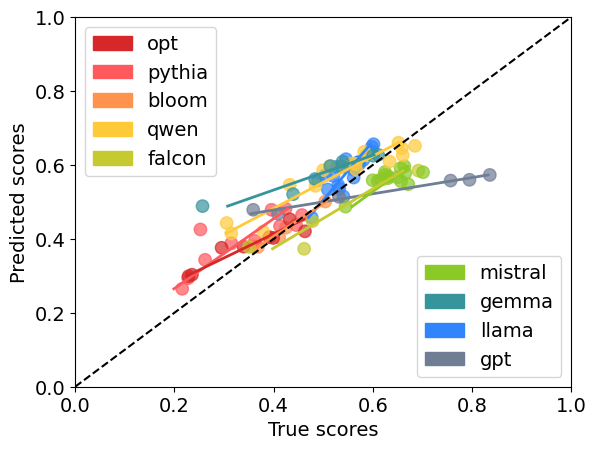

In [17]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import torch

benchmark_index = 0 #0 for arc, 1 for hellaswag, 2 for mmlu, 3 for truthfulqa, 4 for winogrande, 5 for gsm8k

#Prepare the colors for plotting
c = [colors[o.split(' ')[0]] for o in origins]

#Prepare the similarity matrix and labels
similarity_matrix = nei_sim.copy()
labels = [scores[m.name][benchmark_index] for m in models]

#Remove models with no labels
to_keep = []
for i in range(len(labels)):
    if labels[i] is not None and not(np.isnan(labels[i])):
       to_keep.append(i)
similarity_matrix = similarity_matrix[to_keep,:][:,to_keep]
kept_models = [models[i] for i in to_keep]
kept_model_labels = [model_labels[i] for i in to_keep]
labels = [labels[i] for i in to_keep]
c = [c[i] for i in to_keep]
kept_origins = [origins[i].split(' ')[0] for i in to_keep]

#Compute the distance matrix
eps= 10**-10
distance_matrix = -np.log(similarity_matrix+eps)
X = distance_matrix
Y = np.array(labels)

#Compute unique origins
unique_origins = set(kept_origins)

#Train the model on each family (leave-one-family-out)
pred_labels = np.zeros((similarity_matrix.shape[0],1))
for i in unique_origins:
    predicted_labels_rf2,indexs = train(X,kept_model_labels,labels,i,c=c)
    pred_labels[indexs] = predicted_labels_rf2

#Concatenate the predictions for each family
pred_labels = np.concatenate(pred_labels,axis=0)

#Plot the results
fig,ax = plt.subplots()
plt.scatter(labels, pred_labels,c=c,marker='o',edgecolors=c,s=80,alpha=0.7)



#Fit linear model on each family for correlation plot
from sklearn.linear_model import LinearRegression

print('Values might be slightly different from the paper due to the data compression for this code preview')

#Fit linear model on each family
d_stats = {}
for i in unique_origins:
    X_family,Y_family,X_other,Y_other = split_family(pred_labels,labels,kept_origins,i)
    reg = LinearRegression().fit(X_family[:,None],Y_family[:,None])

    #plot line 
    x = np.linspace(min(X_family),max(X_family),100)
    plt.plot(reg.predict(x.reshape(-1,1)),x,color=colors[i],linewidth=2)

    #Compute stats pearson for the family
    r,p = pearsonr(Y_family,reg.predict(X_family[:,None]).flatten())
    print('Pearson correlation for',i,':',r,'p-value:',p)

    #update d
    d_stats[i] = {'r':r,'p':p,'N':len(Y_family)}

#compute correlation with q values
from scipy.stats import pearsonr

r,p = pearsonr(labels,pred_labels)
print('Pearson correlation:',r,'p-value:',p)

name = ['arc','hellaswag','mmlu','truthfulqa','winogrande','gsm8k'][benchmark_index]

#Plot diagonal
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

#Add colors of models to the legend
import matplotlib.patches as mpatches
families_included = set([o.split(' ')[0] for o in origins])
#increase font size to 10
patches = []
colors_list = [
 'opt',
 'pythia',
 'bloom',
 'qwen',
 'falcon',
 'mistral',
 'gemma',
 'llama',
 'gpt',
 'claude',
 'palm',
 'gemini',]
colors_list = [name for name in colors_list if name in families_included]

for k in range(len(colors_list)):
    i = k//2+(len(colors_list)+1)//2*(k%2==1)
    if colors_list[i] in families_included:
        patches.append(mpatches.Patch(color=colors[colors_list[i]], label=colors_list[i]))
fontsize = 14
leg1 = plt.legend(handles=patches[::2],fontsize=fontsize,loc='upper left',ncol=1)
plt.legend(handles=patches[1::2],fontsize=fontsize,loc='lower right',ncol=1)
plt.gca().add_artist(leg1)

plt.xlabel('True scores',fontsize=fontsize)
plt.ylabel('Predicted scores',fontsize=fontsize)
plt.ylim(0,1)
plt.xlim(0,1)
#Increase tick font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#Set white background
fig.patch.set_facecolor('white')
#save svg

plt.savefig(os.path.join(name+'_'+genome_name+'.svg'),format='svg')
plt.show()